In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sys
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.path import Path
from matplotlib.gridspec import GridSpec

BASE_DIR = os.path.dirname('./')
ROOT_DIR = os.path.dirname(BASE_DIR)
sys.path.append(ROOT_DIR)

import yaml
import logging

from lib.helpers.dataloader_helper import build_dataloader
from lib.helpers.model_helper import build_model

In [3]:
mode = 'train' # test, eval, train
config = 'lib/kitti.yaml'

def create_logger(log_file):
    log_format = '%(asctime)s  %(levelname)5s  %(message)s'
    logging.basicConfig(level=logging.INFO, format=log_format, filename=log_file)
    console = logging.StreamHandler()
    console.setLevel(logging.INFO)
    console.setFormatter(logging.Formatter(log_format))
    logging.getLogger(__name__).addHandler(console)
    return logging.getLogger(__name__)

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')


# load cfg
assert (os.path.exists(config))
cfg = yaml.load(open(config, 'r'), Loader=yaml.Loader)
os.makedirs(cfg['trainer']['log_dir'], exist_ok=True)
logger = create_logger(os.path.join(cfg['trainer']['log_dir'], 'train.log'))
cfg['dataset']['batch_size'] = 1

import shutil
if mode != 'eval':
    if not mode != 'test':
        if os.path.exists(os.path.join(cfg['trainer']['log_dir'], 'lib/')):
            shutil.rmtree(os.path.join(cfg['trainer']['log_dir'], 'lib/'))
    if not mode != 'test':
        shutil.copytree('./lib', os.path.join(cfg['trainer']['log_dir'], 'lib/'))
    

#  build dataloader
train_loader, val_loader, test_loader = build_dataloader(cfg['dataset'])

# build model
model = build_model(cfg['model'], train_loader.dataset.cls_mean_size)


Using device: cuda

NVIDIA GeForce RTX 3060
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [4]:
class detectionInfo(object):
    def __init__(self, line):
        self.name = line[0]

        self.truncation = float(line[1])
        self.occlusion = int(line[2])

        # local orientation = alpha + pi/2
        self.alpha = float(line[3])

        # in pixel coordinate
        self.xmin = float(line[4])
        self.ymin = float(line[5])
        self.xmax = float(line[6])
        self.ymax = float(line[7])

        # height, weigh, length in object coordinate, meter
        self.h = float(line[8])
        self.w = float(line[9])
        self.l = float(line[10])

        # x, y, z in camera coordinate, meter
        self.tx = float(line[11])
        self.ty = float(line[12])
        self.tz = float(line[13])

        # global orientation [-pi, pi]
        self.rot_global = float(line[14])

    def member_to_list(self):
        output_line = []
        for name, value in vars(self).items():
            output_line.append(value)
        return output_line

    def box3d_candidate(self, rot_local, soft_range):
        x_corners = [self.l, self.l, self.l, self.l, 0, 0, 0, 0]
        y_corners = [self.h, 0, self.h, 0, self.h, 0, self.h, 0]
        z_corners = [0, 0, self.w, self.w, self.w, self.w, 0, 0]

        x_corners = [i - self.l / 2 for i in x_corners]
        y_corners = [i - self.h for i in y_corners]
        z_corners = [i - self.w / 2 for i in z_corners]

        corners_3d = np.transpose(np.array([x_corners, y_corners, z_corners]))
        point1 = corners_3d[0, :]
        point2 = corners_3d[1, :]
        point3 = corners_3d[2, :]
        point4 = corners_3d[3, :]
        point5 = corners_3d[6, :]
        point6 = corners_3d[7, :]
        point7 = corners_3d[4, :]
        point8 = corners_3d[5, :]

        # set up projection relation based on local orientation
        xmin_candi = xmax_candi = ymin_candi = ymax_candi = 0

        if 0 < rot_local < np.pi / 2:
            xmin_candi = point8
            xmax_candi = point2
            ymin_candi = point2
            ymax_candi = point5

        if np.pi / 2 <= rot_local <= np.pi:
            xmin_candi = point6
            xmax_candi = point4
            ymin_candi = point4
            ymax_candi = point1

        if np.pi < rot_local <= 3 / 2 * np.pi:
            xmin_candi = point2
            xmax_candi = point8
            ymin_candi = point8
            ymax_candi = point1

        if 3 * np.pi / 2 <= rot_local <= 2 * np.pi:
            xmin_candi = point4
            xmax_candi = point6
            ymin_candi = point6
            ymax_candi = point5

        # soft constraint
        div = soft_range * np.pi / 180
        if 0 < rot_local < div or 2*np.pi-div < rot_local < 2*np.pi:
            xmin_candi = point8
            xmax_candi = point6
            ymin_candi = point6
            ymax_candi = point5

        if np.pi - div < rot_local < np.pi + div:
            xmin_candi = point2
            xmax_candi = point4
            ymin_candi = point8
            ymax_candi = point1

        return xmin_candi, xmax_candi, ymin_candi, ymax_candi

In [5]:
def compute_birdviewbox(line, shape, scale):
    npline = [np.float64(line[i]) for i in range(1, len(line))]
    h = npline[7] * scale
    w = npline[8] * scale
    l = npline[9] * scale
    x = npline[10] * scale
    y = npline[11] * scale
    z = npline[12] * scale
    rot_y = npline[13]

    #print('line: name=%s truncated=%f occluded=%f alpha=%f\n bbox=[%f %f %f %f]\n dimensions=[%f %f %f]\n location=[%f %f %f]\n rotation_y=%f score=%f' % (line[0], npline[0], npline[1], npline[2], npline[3], npline[4], npline[5], npline[6], npline[7], npline[8], npline[9], npline[10], npline[11], npline[12], npline[13], npline[14]))

    R = np.array([[-np.cos(rot_y), np.sin(rot_y)],
                  [np.sin(rot_y), np.cos(rot_y)]])
    t = np.array([x, z]).reshape(1, 2).T

    x_corners = [0, l, l, 0]  # -l/2
    z_corners = [w, w, 0, 0]  # -w/2


    x_corners += -w / 2
    z_corners += -l / 2

    # bounding box in object coordinate
    corners_2D = np.array([x_corners, z_corners])
    # rotate
    corners_2D = R.dot(corners_2D)
    # translation
    corners_2D = t - corners_2D
    # in camera coordinate
    corners_2D[0] += int(shape/2)
    corners_2D = (corners_2D).astype(np.int16)
    corners_2D = corners_2D.T

    return np.vstack((corners_2D, corners_2D[0,:]))

def draw_birdeyes(ax2, line_gt, line_p, shape):
    # shape = 900
    scale = 15

    pred_corners_2d = compute_birdviewbox(line_p, shape, scale)
    #gt_corners_2d = compute_birdviewbox(line_gt, shape, scale)

    #codes = [Path.LINETO] * gt_corners_2d.shape[0]
    #codes[0] = Path.MOVETO
    #codes[-1] = Path.CLOSEPOLY
    #pth = Path(gt_corners_2d, codes)
    #p = patches.PathPatch(pth, fill=False, color='orange', label='ground truth')
    #ax2.add_patch(p)

    codes = [Path.LINETO] * pred_corners_2d.shape[0]
    codes[0] = Path.MOVETO
    codes[-1] = Path.CLOSEPOLY
    pth = Path(pred_corners_2d, codes)
    p = patches.PathPatch(pth, fill=False, color='green', label='prediction')
    ax2.add_patch(p)

def compute_3Dbox(P2, line):
    obj = detectionInfo(line)
    # Draw 2D Bounding Box
    xmin = int(obj.xmin)
    xmax = int(obj.xmax)
    ymin = int(obj.ymin)
    ymax = int(obj.ymax)
    # width = xmax - xmin
    # height = ymax - ymin
    # box_2d = patches.Rectangle((xmin, ymin), width, height, fill=False, color='red', linewidth='3')
    # ax.add_patch(box_2d)

    # Draw 3D Bounding Box

    R = np.array([[np.cos(obj.rot_global), 0, np.sin(obj.rot_global)],
                  [0, 1, 0],
                  [-np.sin(obj.rot_global), 0, np.cos(obj.rot_global)]])

    x_corners = [0, obj.l, obj.l, obj.l, obj.l, 0, 0, 0]  # -l/2
    y_corners = [0, 0, obj.h, obj.h, 0, 0, obj.h, obj.h]  # -h
    z_corners = [0, 0, 0, obj.w, obj.w, obj.w, obj.w, 0]  # -w/2

    x_corners = [i - obj.l / 2 for i in x_corners]
    y_corners = [i - obj.h for i in y_corners]
    z_corners = [i - obj.w / 2 for i in z_corners]

    corners_3D = np.array([x_corners, y_corners, z_corners])
    corners_3D = R.dot(corners_3D)
    corners_3D += np.array([obj.tx, obj.ty, obj.tz]).reshape((3, 1))

    corners_3D_1 = np.vstack((corners_3D, np.ones((corners_3D.shape[-1]))))
    corners_2D = P2.dot(corners_3D_1)
    corners_2D = corners_2D / corners_2D[2]
    corners_2D = corners_2D[:2]

    return corners_2D

def draw_3Dbox(ax, P2, line, color):

    corners_2D = compute_3Dbox(P2, line)

    # draw all lines through path
    # https://matplotlib.org/users/path_tutorial.html
    bb3d_lines_verts_idx = [0, 1, 2, 3, 4, 5, 6, 7, 0, 5, 4, 1, 2, 7, 6, 3]
    bb3d_on_2d_lines_verts = corners_2D[:, bb3d_lines_verts_idx]
    verts = bb3d_on_2d_lines_verts.T
    codes = [Path.LINETO] * verts.shape[0]
    codes[0] = Path.MOVETO
    # codes[-1] = Path.CLOSEPOLYq
    pth = Path(verts, codes)
    p = patches.PathPatch(pth, fill=False, color=color, linewidth=2)

    width = corners_2D[:, 3][0] - corners_2D[:, 1][0]
    height = corners_2D[:, 2][1] - corners_2D[:, 1][1]
    # put a mask on the front
    front_fill = patches.Rectangle((corners_2D[:, 1]), width, height, fill=True, color=color, alpha=0.4)
    ax.add_patch(p)
    ax.add_patch(front_fill)

In [6]:
def visualization(image, calib, _, f2):

    P2 = calib[0].P2

    fig = plt.figure(figsize=(20.00, 5.12), dpi=100)

    # fig.tight_layout()
    gs = GridSpec(1, 4)
    gs.update(wspace=0)  # set the spacing between axes.

    ax = fig.add_subplot(gs[0, :3])
    ax2 = fig.add_subplot(gs[0, 3:])

    # with writer.saving(fig, "kitti_30_20fps.mp4", dpi=100):
    shape = 900
    birdimage = np.zeros((shape, shape, 3), np.uint8)

    #with open(label_file) as f1, open(prediction_file) as f2:
        #for line_gt, line_p in zip(f1, f2):
    for line_p in f2:
        #line_gt = line_gt.strip().split(' ')

        truncated = np.abs(float(line_p[1]))
        occluded = np.abs(float(line_p[2]))
        trunc_level = 255

    # truncated object in dataset is not observable
        if truncated < trunc_level:
            color = 'green'
            if line_p[0] == 'Cyclist':
                color = 'yellow'
            elif line_p[0] == 'Pedestrian':
                color = 'cyan'
            draw_3Dbox(ax, P2, line_p, color)
            draw_birdeyes(ax2, ['any'], line_p, shape)

    # visualize 3D bounding box
    ax.imshow(image)
    ax.set_xticks([]) #remove axis value
    ax.set_yticks([])

    # plot camera view range
    x1 = np.linspace(0, shape / 2)
    x2 = np.linspace(shape / 2, shape)
    ax2.plot(x1, shape / 2 - x1, ls='--', color='grey', linewidth=1, alpha=0.5)
    ax2.plot(x2, x2 - shape / 2, ls='--', color='grey', linewidth=1, alpha=0.5)
    ax2.plot(shape / 2, 0, marker='+', markersize=16, markeredgecolor='red')

    # visualize bird eye view
    ax2.imshow(birdimage, origin='lower')
    ax2.set_xticks([])
    ax2.set_yticks([])
    # add legend
    #handles, labels = ax2.get_legend_handles_labels()
    #legend = ax2.legend([handles[0], handles[1]], [labels[0], labels[1]], loc='lower right',
    #                    fontsize='x-small', framealpha=0.2)
    #for text in legend.get_texts():
    #    plt.setp(text, color='w')

    #print(dataset[index])
    plt.show()
    # video_writer.write(np.uint8(fig))



In [7]:
import torch
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

from lib.helpers.save_helper import load_checkpoint
from lib.helpers.decode_helper import extract_dets_from_outputs
from lib.helpers.decode_helper import decode_detections
from lib.datasets.kitti_utils import get_affine_transform

class PrintHelper(object):
    def __init__(self, cfg, cfg_dataset, model, data_loader, logger):
        self.cfg = cfg
        self.model = model
        self.data_loader = data_loader
        self.logger = logger
        self.class_name = data_loader.dataset.class_name
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.label_dir = cfg_dataset['label_dir']
        self.eval_cls = cfg_dataset['eval_cls']

        if self.cfg.get('resume_model', None):
            load_checkpoint(model = self.model,
                        optimizer = None,
                        filename = cfg['resume_model'],
                        logger = self.logger,
                        map_location=self.device)
        self.model.to(self.device)

    def print(self, idx):

        dataset = self.data_loader.dataset

        img = dataset.get_image(idx)
        calib = dataset.get_calib(idx)
        img_size = np.array(img.size)


        center = np.array(img_size) / 2
        crop_size = img_size
        coord_range = np.array([center-crop_size/2,center+crop_size/2]).astype(np.float32)

        trans, trans_inv = get_affine_transform(center, crop_size, 0, dataset.resolution, inv=1)
        inputs = img.transform(tuple(dataset.resolution.tolist()),
                            method=Image.AFFINE,
                            data=tuple(trans_inv.reshape(-1).tolist()),
                            resample=Image.BILINEAR)
        inputs = np.array(inputs).astype(np.float32) / 255.0
        inputs = (inputs - dataset.mean) / dataset.std
        inputs = inputs.transpose(2, 0, 1)  # C * H * W

        features_size = dataset.resolution // dataset.downsample
        info = {'img_id': np.asarray([idx]),
                'img_size': np.asarray([img_size]),
                'bbox_downsample_ratio': np.asarray([img_size/features_size])}


        torch.set_grad_enabled(False)
        self.model.eval()
        inputs = torch.Tensor(inputs).unsqueeze(0).to(self.device)
        calib = torch.Tensor(calib.P2).unsqueeze(0).to(self.device)
        coord_ranges = torch.Tensor(coord_range).unsqueeze(0).to(self.device)
        outputs = self.model(inputs, coord_ranges, calib, K=50, mode='test')

        dets = extract_dets_from_outputs(outputs=outputs, K=50)
        dets = dets.detach().cpu().numpy()
        # get corresponding calibs & transform tensor to numpy
        calibs = [dataset.get_calib(idx)]
        info = {key: val for key, val in info.items()}
        cls_mean_size = dataset.cls_mean_size

        dets = decode_detections(
            dets = dets,
            info = info,
            calibs = calibs,
            cls_mean_size=cls_mean_size,
            threshold = self.cfg['threshold']
        )

        return img, calibs, coord_ranges, info, dets

# evaluation mode
if mode == 'eval':
    print('evaluation mode')
    printer = PrintHelper(cfg['tester'], cfg['dataset'], model, val_loader, logger)
elif mode == 'test':
    print('test mode')
    printer = PrintHelper(cfg['tester'], cfg['dataset'], model, test_loader, logger)
else:
    print('train mode')
    printer = PrintHelper(cfg['tester'], cfg['dataset'], model, train_loader, logger)

2024-10-02 19:53:24,778   INFO  ==> Loading from checkpoint './checkpoints/model.pth'


train mode


/home/akos/Documents/code/MonoLSS/lib/helpers/save_helper.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename, map_location=map_location)
2

In [8]:
idx = 0

8
[['Car', -1, -1, -1.337773890295301, 595.3662776827812, 178.66511642932892, 721.7073879361153, 263.96922767162323, 1.4153854846954346, 1.6058639287948608, 3.796213388442993, 1.0646860203734356, 1.5791152224501679, 14.418360710144043, -1.2699985133861311, 0.5923092], ['Car', -1, -1, 1.9910902543182822, 327.1589609384537, 174.16172474622726, 617.377955031395, 364.89052325487137, 1.5610095262527466, 1.638122320175171, 3.8058230876922607, -1.2253141149250466, 1.6011279799542293, 7.853733062744141, 1.8030625302158554, 0.6630422], ['Car', -1, -1, -1.5957089560714106, 886.6841429829598, 177.02513374388218, 953.274370086193, 239.06136117875576, 1.5433604717254639, 1.596317172050476, 3.1852126121520996, 8.448937853786882, 1.6826835004378107, 19.918394088745117, -1.1894252749661267, 0.36777294], ['Car', -1, -1, 1.7170272479441504, 737.8571480154991, 167.563296854496, 790.7307843804359, 207.8126296401024, 1.7046231031417847, 1.7174829244613647, 4.287024974822998, 7.153698405180598, 1.5143994971

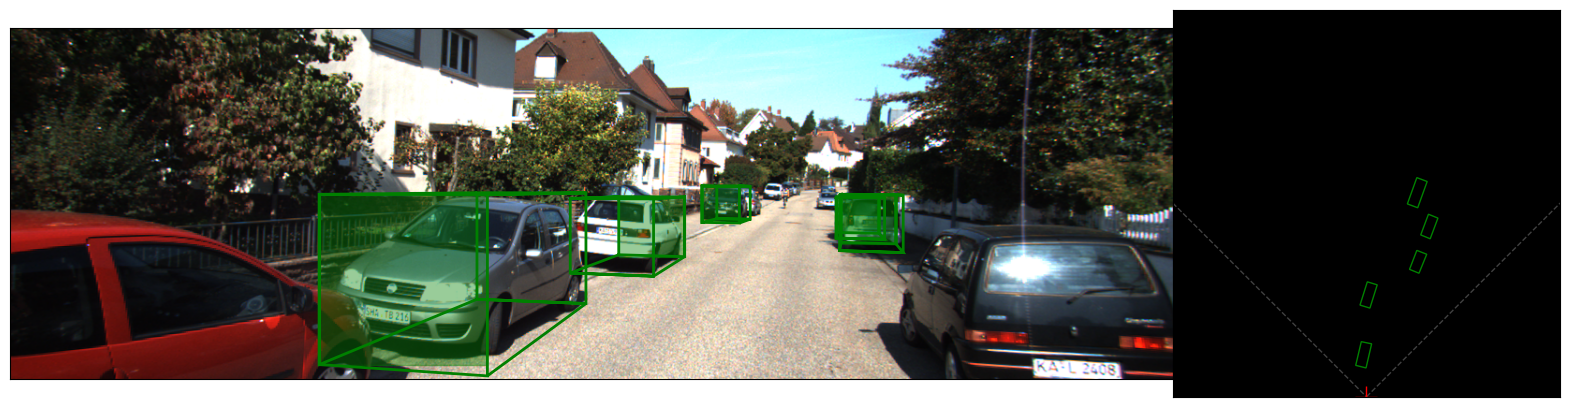

In [17]:
print(idx)
img, calibs, coord_ranges, info, dets = printer.print(idx)
dets = dets[idx]
preds = []
class_map = {
    0: 'Pedestrian', 
    1: 'Car', 
    2: 'Cyclist'
}

for d in dets:
    cls = class_map[d[0]]
    tmp = [cls, -1, -1]
    tmp.extend(d[1:])
    preds.append(tmp)
print(preds)
visualization(img, calibs, [], preds)

idx = idx + 1